<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/Laboratorio_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219
Intersemestral 2020

# Integrantes

*   Juan José Villegas
*   Juan Sebastián Méndez

## Taller
## Segundo Problema

Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:
<ol type="a">
  <li>Entrenamiento de un perceptrón multicapa.</li>
  <li>Entrenamiento de un undercompleted autoencoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.</li>
  <li>Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).</li>
</ol>

Para los puntos b) y c) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.


# 0. Importar librerias

In [47]:
import pandas as pd
import numpy as np
import random
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

from keras.wrappers.scikit_learn import KerasClassifier

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Descarga de los datos

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# 2. Perfilamiento y entendimiento de los datos

In [3]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)
y_train shape:  (60000,)
y_test shape:  (10000,)


In [4]:
df_y_train = pd.DataFrame(y_train)
ProfileReport(df_y_train)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


In [5]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [6]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Podemos ver que tenemos 60000 imagenes en el conjunto de entrenamiento, 10000 en test, que cada imagen es una matriz de 28x28 pixeles, representada por un numero entre 0 y 255 donde 0 es negro y 255 es blanco, y en total tenemos 10 clases diferentes.

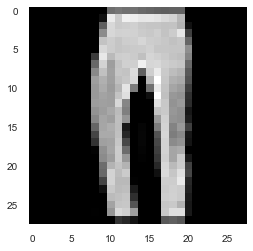

In [7]:
# select any random index from 1 to 60,000
i = random.randint(1,60000)
plt.imshow(X_train[i] , cmap = 'gray')

In [8]:
label = y_train[i]
label

1

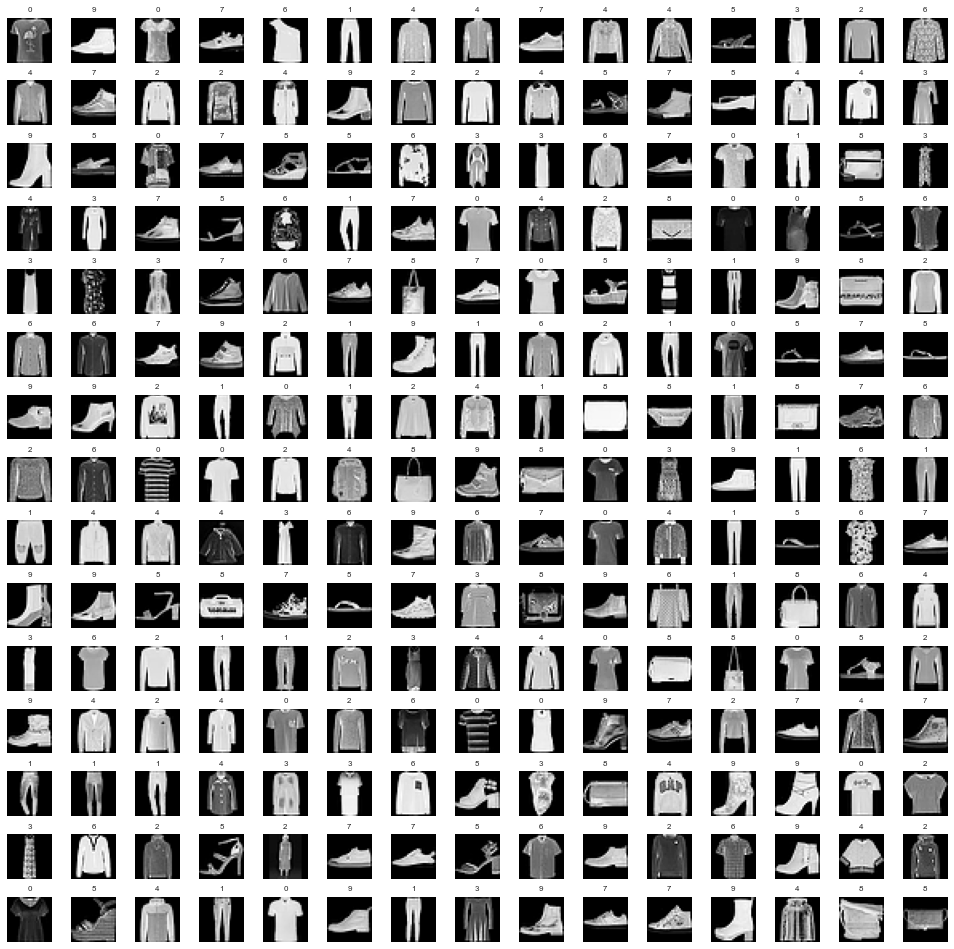

In [9]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( X_train[index], cmap='gray')
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

# 3. Preparación de datos

In [10]:
# Escalamos los datos para que cada pixel este entre 0 y 1
X_train = X_train / 255
X_test = X_test / 255

Se agrega ruido a los datos:

In [11]:
def noising_image(data, noise_factor):
  noise_dataset = []
  for img in data:
    noisy_image = img + noise_factor * np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    noise_dataset.append(noisy_image)
  
  noise_dataset = np.array(noise_dataset)
  return noise_dataset

In [12]:
X_train_noise = noising_image(X_train, 0.2)
X_test_noise = noising_image(X_test, 0.2)

In [13]:
print(X_train_noise.shape)
print(X_test_noise.shape)

(60000, 28, 28)
(10000, 28, 28)


Visualizamos como es el resultado de agregar ruido a una de las imagenes:

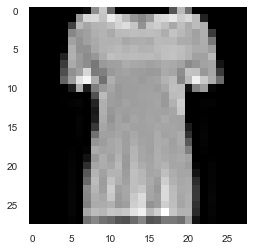

In [14]:
plt.imshow(X_train[10], cmap="gray")

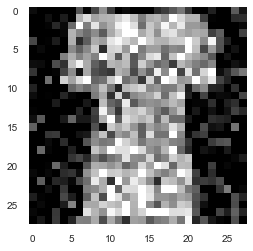

In [15]:
plt.imshow(X_train_noise[10], cmap="gray")

Por ultimo, pasamos los y_train a su versión dummy.

In [16]:
y_train = pd.get_dummies(y_train)
y_train

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,1,0,0,0,0
59996,0,1,0,0,0,0,0,0,0,0
59997,0,0,0,1,0,0,0,0,0,0
59998,1,0,0,0,0,0,0,0,0,0


In [17]:
y_test = pd.get_dummies(y_test)
y_test

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,1
9996,0,1,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,1,0
9998,0,1,0,0,0,0,0,0,0,0


# 3. Modelamiento

## 3.1. Entrenamiento de un perceptrón multicapa.

In [18]:
# Utilizamos un callback de early stopping con una "paciencia" de 3.
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

n_output = 10

In [19]:
def build_mlp_model(n_hidden=1, n_neurons_1 = 100, n_neurons_2 = 100, dropout = 0.1, activation_hidden = 'relu', learning_rate=3e-3):
    mlp = Sequential(name='lab_6_mlp')
    first = True

    mlp.add(Flatten(input_shape=[28,28]))
    for layer in range(n_hidden):
        if first:
            mlp.add(Dense(n_neurons_1, activation=activation_hidden, name=f'hidden_layer_{layer}'))
            first = False
        else:
            mlp.add(Dense(n_neurons_2, activation=activation_hidden, name=f'hidden_layer_{layer}'))
    
    mlp.add(Dropout(dropout,name=f'dropout_layer_{dropout}'))
    mlp.add(Dense(n_output, activation='sigmoid', name= 'output_layer'))

    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    mlp.compile(loss='categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])
    
    return mlp

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=build_mlp_model, epochs=20, batch_size=32, verbose=1,shuffle = True)

In [20]:
param_grid = dict(n_hidden = [1,2],
                  n_neurons_1 = [100, 512, 10000],
                  n_neurons_2 = [100, 512, 10000],
                  dropout = [0.1,0.2,0.3],
                  activation_hidden = ['relu','sigmoid'],
                  learning_rate = [0.03, 0.1, 0.3]
                  )

grid = RandomizedSearchCV(modelCV, param_grid, verbose=1, cv = 3, n_iter=10, random_state=20)

In [21]:
grid.fit(X_train, y_train, callbacks=callbacks)

mlp_model = grid.best_estimator_

==] - 4s 4ms/step - loss: 0.2837 - accuracy: 0.8993
Epoch 15/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2778 - accuracy: 0.9007
Epoch 16/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2696 - accuracy: 0.9049
Epoch 17/20
1250/1250 [==============================] - 4s 4ms/step - loss: 0.2654 - accuracy: 0.9042
Epoch 18/20
1250/1250 [==============================] - 4s 4ms/step - loss: 0.2581 - accuracy: 0.9093
Epoch 19/20
1250/1250 [==============================] - 4s 4ms/step - loss: 0.2517 - accuracy: 0.9111
Epoch 20/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3307 - accuracy: 0.8803
Epoch 1/20
1250/1250 [==============================] - 4s 4ms/step - loss: 0.6894 - accuracy: 0.7718
Epoch 2/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4812 - accuracy: 0.8343
Epoch 3/20
1250/1250 [==============================] - 4s 4ms/step - loss: 0.4360 - accuracy: 0.8487
Epoch 4/20
1250/1250 [====

In [26]:
print(grid.best_params_)
print('Best score: ',grid.best_score_)
print(mlp_model)
mlp_model.model.save("lab6_mlp.h5")
mlp_model.model.summary()

{'n_neurons_2': 10000, 'n_neurons_1': 512, 'n_hidden': 2, 'learning_rate': 0.3, 'dropout': 0.2, 'activation_hidden': 'relu'}
Best score:  0.8882333437601725
Model: "lab_6_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_30 (Flatten)         (None, 784)               0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 512)               401920    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 10000)             5130000   
_________________________________________________________________
dropout_layer_0.2 (Dropout)  (None, 10000)             0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                100010    
Total params: 5,631,930
Trainable params: 5,631,930
Non-trainable params: 0
______________________

## 3.2. Entrenamiento de un undercompleted autoencoder

## 3.3. Entrenamiento de un denoising autoendoder

# 4. Predicción

Comparamos los tres modelos:

In [39]:
y_pred_train = mlp_model.predict(X_train)
y_pred_test = mlp_model.predict(X_test)

y_pred_train = pd.get_dummies(y_pred_train)
y_pred_test = pd.get_dummies(y_pred_test)

313/313 [==============================] - 1s 2ms/step


# 5. Validación

In [45]:
print('Resultados sobre train')
print(classification_report(y_train, y_pred_train))
print('Resultados sobre test')
print(classification_report(y_test, y_pred_test))

Resultados sobre train
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6000
           1       1.00      1.00      1.00      6000
           2       0.88      0.89      0.88      6000
           3       0.97      0.93      0.95      6000
           4       0.90      0.88      0.89      6000
           5       1.00      1.00      1.00      6000
           6       0.81      0.87      0.84      6000
           7       0.94      0.99      0.97      6000
           8       1.00      0.99      0.99      6000
           9       0.99      0.94      0.97      6000

   micro avg       0.94      0.94      0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000
 samples avg       0.94      0.94      0.94     60000

Resultados sobre test
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.99      0.98

Text(50.760000000000005, 0.5, 'predicted label')

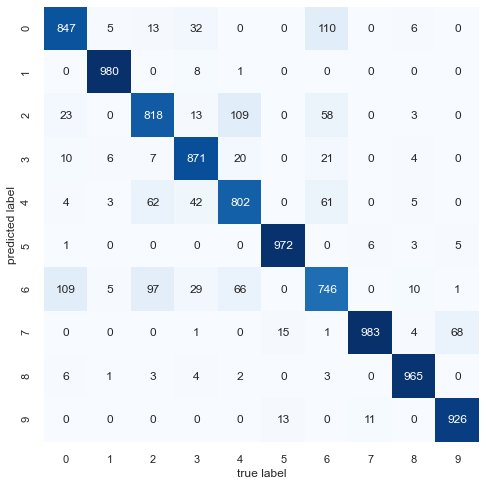

In [51]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.values.argmax(axis=1), y_pred_test.values.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('true label')
plt.ylabel('predicted label')